# C2 Beaconing Detection using Statistical Analysis
### Simplified RITA beacon analyzer implementation in Jupyther Notebook.
### RITA framework ingests Zeek logs in CSV format. This implementation inges PCAP files.
#### Implementation based on https://github.com/Cyb3r-Monk/RITA-J.

## Introduction

How to differ user traffic from beacon traffic using statistical analysis: https://infosecjupyterthon.com/2021/sessions/day2-5-C2_Beaconing_Detection_using_Statistical_Analysis.html. 
TLDR:
- If beacon traffic ==> **uniform** distribution and **small** Median Absolute Deviation of time deltas
- If user traffic ==> **skewed** distribution and **large** Median Absolute Deviation of time deltas


In [34]:
import math
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Preparing the data

### Loading the data

In order to operate on the data later you have to import it into Pandas Dataframe. The easiest way to do so is to convert PCAP file to CSV format using external tools.
- open PCAP file in Wireshark
- File -> Export Packet Dissections -> As CSV...
- Save file in this notebook's location as traffic.csv

Example traffic pcap used below: https://www.malware-traffic-analysis.net/2020/12/15/2020-12-15-Qakbot-infection-part-2-with-Cobalt-Strike.pcap.zip

In [35]:
df = pd.read_csv('traffic.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67276 entries, 0 to 67275
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   No.          67276 non-null  int64  
 1   Time         67276 non-null  float64
 2   Source       67276 non-null  object 
 3   Destination  67276 non-null  object 
 4   Protocol     67276 non-null  object 
 5   Length       67276 non-null  int64  
 6   Info         67276 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 3.6+ MB


## Filtering Required Columns
For this task we don't need *Length*, *Info* and *No.* columns (Pandas creates number(*#*) column by ielf). In order to filter columns in Pandas:
```python
 df.loc[first_row_index:last_row_index , ['column1', 'column3']] #if you need to leave all rows type just: ":"
```

In [36]:
time = 'Time'
src = 'Source'
dst = 'Destination'
proto = 'Protocol'

df = df.loc[:, [time, src, dst, proto]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67276 entries, 0 to 67275
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         67276 non-null  float64
 1   Source       67276 non-null  object 
 2   Destination  67276 non-null  object 
 3   Protocol     67276 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.1+ MB


## Analysing the Data

### Grouping the Connections

Now we need to group the connections beetween the same hos and agregate timestamps into a list.

In [37]:
df = df.groupby([src, dst, proto]).agg(list) #TODO: tutaj na razie wywalilem proto z kolumn i zobacze co wyjdzie
df.head(30)

Time
Source       Destination    Protocol                                                       
10.12.15.101 10.12.15.15    CLDAP         [723.65251, 996.284758, 996.629503, 2120.18524...
                            DCERPC        [996.402381, 996.404133, 996.40486, 2120.30634...
                            DNS           [591.575815, 694.549289, 723.243726, 723.33897...
                            DRSUAPI       [996.405217, 996.405568, 996.405901, 2120.3118...
                            EPM           [996.40286, 2120.3067, 2120.313517, 5720.28495...
                            KRB5                 [16001.985029, 16001.986043, 16001.987356]
                            LDAP          [996.612962, 996.615569, 996.627314, 996.74676...
                            LSARPC                 [10589.206797, 10589.20761, 10589.20842]
                            NTP           [1749.464654, 3797.481993, 5845.527752, 7893.5...
                            RPC_NETLOGON          [6146.607605, 12447.514515, 18747.513923]
                            SMB           [511.550465, 997.066079, 1411.624522, 2311.687...
                            SMB2          [400.478648, 511.551121, 511.553073, 511.55653...
                            TCP           [40.176494, 160.177513, 280.178683, 400.192905...
             10.12.15.255   BROWSER       [153.144956, 871.470855, 1593.660667, 2310.785...
             104.43.139.144 TCP           [12787.254694, 12787.315072, 12787.382208, 127...
                            TLSv1.2       [12787.317169, 12787.388674, 12787.456146, 127...
             104.95.94.118  TCP           [13253.525279, 13253.557129, 13253.606181, 132...
                            TLSv1.2               [13253.559149, 13253.637928, 13253.66769]
             13.107.5.88    TCP           [5720.295047, 5720.346143, 5720.398278, 5720.3...
                            TLSv1.2       [5720.346532, 5720.407951, 5720.409404, 5720.4...
             13.64.90.137   TCP           [13542.592505, 13542.663446, 13542.752502, 135...
                            TLSv1.2       [13542.66542, 13542.756513, 13542.839235, 1354...
             13.88.21.125   TCP           [14105.631661, 14105.704298, 14105.79212, 1410...
                            TLSv1.2       [14105.705695, 14105.794336, 14105.87704, 1410...
             13.88.28.53    TCP           [7894.671865, 7894.744986, 7894.83318, 7895.02...
                            TLSv1.2       [7894.74563, 7894.837103, 7894.920544, 7894.92...
             138.91.140.216 TCP           [11487.409149, 11487.483148, 11487.573179, 114...
                            TLSv1.2       [11487.483726, 11487.58014, 11487.667551, 1148...
             172.217.14.163 TCP           [5764.776317, 5764.818004, 5764.881042, 5765.0...
                            TLSv1.2       [5764.819492, 5764.910225, 5764.962135, 5764.9...

### Reseting the Indexes

In [38]:
df.reset_index(inplace=True)
df.head(20)

,Source,Destination,Protocol,Time
0,10.12.15.101,10.12.15.15,CLDAP,"[723.65251, 996.284758, 996.629503, 2120.18524..."
1,10.12.15.101,10.12.15.15,DCERPC,"[996.402381, 996.404133, 996.40486, 2120.30634..."
2,10.12.15.101,10.12.15.15,DNS,"[591.575815, 694.549289, 723.243726, 723.33897..."
3,10.12.15.101,10.12.15.15,DRSUAPI,"[996.405217, 996.405568, 996.405901, 2120.3118..."
4,10.12.15.101,10.12.15.15,EPM,"[996.40286, 2120.3067, 2120.313517, 5720.28495..."
5,10.12.15.101,10.12.15.15,KRB5,"[16001.985029, 16001.986043, 16001.987356]"
6,10.12.15.101,10.12.15.15,LDAP,"[996.612962, 996.615569, 996.627314, 996.74676..."
7,10.12.15.101,10.12.15.15,LSARPC,"[10589.206797, 10589.20761, 10589.20842]"
8,10.12.15.101,10.12.15.15,NTP,"[1749.464654, 3797.481993, 5845.527752, 7893.5..."
9,10.12.15.101,10.12.15.15,RPC_NETLOGON,"[6146.607605, 12447.514515, 18747.513923]"


### Calculationg connection count

In [39]:
count = 'Count'
df[count] = df[time].apply(lambda x: len(x))
df.head(20)

,Source,Destination,Protocol,Time,Count
0,10.12.15.101,10.12.15.15,CLDAP,"[723.65251, 996.284758, 996.629503, 2120.18524...",44
1,10.12.15.101,10.12.15.15,DCERPC,"[996.402381, 996.404133, 996.40486, 2120.30634...",41
2,10.12.15.101,10.12.15.15,DNS,"[591.575815, 694.549289, 723.243726, 723.33897...",123
3,10.12.15.101,10.12.15.15,DRSUAPI,"[996.405217, 996.405568, 996.405901, 2120.3118...",51
4,10.12.15.101,10.12.15.15,EPM,"[996.40286, 2120.3067, 2120.313517, 5720.28495...",20
5,10.12.15.101,10.12.15.15,KRB5,"[16001.985029, 16001.986043, 16001.987356]",3
6,10.12.15.101,10.12.15.15,LDAP,"[996.612962, 996.615569, 996.627314, 996.74676...",116
7,10.12.15.101,10.12.15.15,LSARPC,"[10589.206797, 10589.20761, 10589.20842]",3
8,10.12.15.101,10.12.15.15,NTP,"[1749.464654, 3797.481993, 5845.527752, 7893.5...",7
9,10.12.15.101,10.12.15.15,RPC_NETLOGON,"[6146.607605, 12447.514515, 18747.513923]",3


### Removing short sessions

Removing short session will help us get rid of many false-positives. We are also resetting the indexes again to get rid of gaps.

In [40]:
df = df.loc[df[count] > 36]
df.reset_index(inplace=True)
df = df.loc[:, [src, dst, proto, time, count]]
df.head(20)

,Source,Destination,Protocol,Time,Count
0,10.12.15.101,10.12.15.15,CLDAP,"[723.65251, 996.284758, 996.629503, 2120.18524...",44
1,10.12.15.101,10.12.15.15,DCERPC,"[996.402381, 996.404133, 996.40486, 2120.30634...",41
2,10.12.15.101,10.12.15.15,DNS,"[591.575815, 694.549289, 723.243726, 723.33897...",123
3,10.12.15.101,10.12.15.15,DRSUAPI,"[996.405217, 996.405568, 996.405901, 2120.3118...",51
4,10.12.15.101,10.12.15.15,LDAP,"[996.612962, 996.615569, 996.627314, 996.74676...",116
5,10.12.15.101,10.12.15.15,SMB2,"[400.478648, 511.551121, 511.553073, 511.55653...",411
6,10.12.15.101,10.12.15.15,TCP,"[40.176494, 160.177513, 280.178683, 400.192905...",715
7,10.12.15.101,172.241.27.244,HTTP,"[13467.840805, 13527.940792, 13533.041096, 135...",2501
8,10.12.15.101,172.241.27.244,TCP,"[13406.400747, 13406.434748, 13406.483509, 134...",19007
9,10.12.15.101,172.241.27.244,TLSv1.2,"[13406.437224, 13406.578584, 13406.692834, 134...",3466


### Calculationg time deltas

We need to create new column containing time deltas beetween following connections. This step is required for further calculations.

In [41]:
dlt = 'Deltas'
df[dlt] = df[time].apply(lambda x: pd.Series(x).diff().dropna().tolist())
df.head(20)

,Source,Destination,Protocol,Time,Count,Deltas
0,10.12.15.101,10.12.15.15,CLDAP,"[723.65251, 996.284758, 996.629503, 2120.18524...",44,"[272.632248, 0.344744999999989, 1123.555738, 3..."
1,10.12.15.101,10.12.15.15,DCERPC,"[996.402381, 996.404133, 996.40486, 2120.30634...",41,"[0.001752000000010412, 0.0007269999999834909, ..."
2,10.12.15.101,10.12.15.15,DNS,"[591.575815, 694.549289, 723.243726, 723.33897...",123,"[102.97347400000001, 28.694436999999994, 0.095..."
3,10.12.15.101,10.12.15.15,DRSUAPI,"[996.405217, 996.405568, 996.405901, 2120.3118...",51,"[0.0003510000000233049, 0.0003329999999550637,..."
4,10.12.15.101,10.12.15.15,LDAP,"[996.612962, 996.615569, 996.627314, 996.74676...",116,"[0.0026070000000117943, 0.011744999999905303, ..."
5,10.12.15.101,10.12.15.15,SMB2,"[400.478648, 511.551121, 511.553073, 511.55653...",411,"[111.072473, 0.0019519999999602078, 0.00346300..."
6,10.12.15.101,10.12.15.15,TCP,"[40.176494, 160.177513, 280.178683, 400.192905...",715,"[120.00101900000001, 120.00116999999997, 120.0..."
7,10.12.15.101,172.241.27.244,HTTP,"[13467.840805, 13527.940792, 13533.041096, 135...",2501,"[60.0999869999996, 5.100304000001415, 5.101183..."
8,10.12.15.101,172.241.27.244,TCP,"[13406.400747, 13406.434748, 13406.483509, 134...",19007,"[0.03400099999998929, 0.048761000000013155, 0...."
9,10.12.15.101,172.241.27.244,TLSv1.2,"[13406.437224, 13406.578584, 13406.692834, 134...",3466,"[0.14136000000144122, 0.11424999999871943, 0.2..."


### Generating variables required for score calculation

In [42]:
df['Low'] = df[dlt].apply(lambda x: np.percentile(np.array(x), 20))
df['Mid'] = df[dlt].apply(lambda x: np.percentile(np.array(x), 50))
df['High'] = df[dlt].apply(lambda x: np.percentile(np.array(x), 80))
df['BowleyNum'] = df['Low'] + df['High'] - 2 * df['Mid'] 
df['BowleyDen'] = df['High'] - df['Low'] 
df['Skew'] = df[['Low', 'Mid', 'High', 'BowleyNum', 'BowleyDen']].apply(lambda x: x['BowleyNum'] / x['BowleyDen'] if x['BowleyNum'] != 0 and x['Mid'] != x['Low'] and x['Mid'] != x['High'] else 0.0, axis = 1)
df['Madm'] = df[dlt].apply(lambda x: np.median(np.absolute(np.array(x) - np.median(np.array(x)))))
df['ConnDiv'] = df[time].apply(lambda x: x[-1] - x[0]) 
df.head(5)

,Source,Destination,Protocol,Time,Count,Deltas,Low,Mid,High,BowleyNum,BowleyDen,Skew,Madm,ConnDiv
0,10.12.15.101,10.12.15.15,CLDAP,"[723.65251, 996.284758, 996.629503, 2120.18524...",44,"[272.632248, 0.344744999999989, 1123.555738, 3...",0.391889,68.554068,950.212076,813.495829,949.820186,0.856474,68.433433,19317.787009
1,10.12.15.101,10.12.15.15,DCERPC,"[996.402381, 996.404133, 996.40486, 2120.30634...",41,"[0.001752000000010412, 0.0007269999999834909, ...",0.001005,0.002455,1152.898627,1152.894721,1152.897622,0.999997,0.001671,17751.112642
2,10.12.15.101,10.12.15.15,DNS,"[591.575815, 694.549289, 723.243726, 723.33897...",123,"[102.97347400000001, 28.694436999999994, 0.095...",0.488819,86.548064,330.717928,158.110618,330.229108,0.478791,85.759133,19449.862799
3,10.12.15.101,10.12.15.15,DRSUAPI,"[996.405217, 996.405568, 996.405901, 2120.3118...",51,"[0.0003510000000233049, 0.0003329999999550637,...",0.000350,0.000544,123.158353,123.157615,123.158003,0.999997,0.000208,17751.111674
4,10.12.15.101,10.12.15.15,LDAP,"[996.612962, 996.615569, 996.627314, 996.74676...",116,"[0.0026070000000117943, 0.011744999999905303, ...",0.000438,0.001417,0.012073,0.009677,0.011635,0.831680,0.001108,17751.691632


### Calculating the score

In [43]:
score = 'Score'
df['SkewScore'] = 1.0 - abs(df['Skew'])
df['MadmScore'] = 1.0 - df['Madm']/30.0
df['MadmScore'] = df['MadmScore'].apply(lambda x: 0 if x < 0 else x)
df['ConnCountScore'] = 10 * (df[count]) / df['ConnDiv']
df['ConnCountScore'] = df['ConnCountScore'].apply(lambda x: 1.0 if x > 1.0 else x)
df[score] = (((df['SkewScore'] + df['MadmScore'] + df['ConnCountScore']) / 3.0) * 1000) / 1000
df.sort_values(by= 'Score', ascending=False, inplace=True, ignore_index=True)
df[[score, count, src, dst, proto, dlt]].head(5)


,Score,Count,Source,Destination,Protocol,Deltas
0,0.982519,1282,185.125.206.173,10.12.15.101,HTTP,"[60.32279100000051, 60.331709999998566, 5.3335..."
1,0.966995,1282,10.12.15.101,185.125.206.173,HTTP,"[60.326828000001115, 60.331803999999465, 5.328..."
2,0.920385,19007,10.12.15.101,172.241.27.244,TCP,"[0.03400099999998929, 0.048761000000013155, 0...."
3,0.896604,2501,172.241.27.244,10.12.15.101,HTTP,"[60.10095299999921, 5.1002430000007735, 5.0978..."
4,0.895981,2501,10.12.15.101,172.241.27.244,HTTP,"[60.0999869999996, 5.100304000001415, 5.101183..."


We can get rid off all redundant columns.

In [44]:
df = df.loc[:, [score, count, src, dst, proto, dlt]]
df.head(20)

,Score,Count,Source,Destination,Protocol,Deltas
0,0.982519,1282,185.125.206.173,10.12.15.101,HTTP,"[60.32279100000051, 60.331709999998566, 5.3335..."
1,0.966995,1282,10.12.15.101,185.125.206.173,HTTP,"[60.326828000001115, 60.331803999999465, 5.328..."
2,0.920385,19007,10.12.15.101,172.241.27.244,TCP,"[0.03400099999998929, 0.048761000000013155, 0...."
3,0.896604,2501,172.241.27.244,10.12.15.101,HTTP,"[60.10095299999921, 5.1002430000007735, 5.0978..."
4,0.895981,2501,10.12.15.101,172.241.27.244,HTTP,"[60.0999869999996, 5.100304000001415, 5.101183..."
5,0.728500,6293,10.12.15.101,185.125.206.173,TCP,"[0.1507209999999759, 0.0036259999997128034, 0...."
6,0.703349,15858,172.241.27.244,10.12.15.101,TCP,"[0.0027329999993526144, 0.14135900000110269, 0..."
7,0.685554,5350,185.125.206.173,10.12.15.101,TCP,"[0.00395599999865226, 0.15628800000013143, 0.1..."
8,0.680210,3466,10.12.15.101,172.241.27.244,TLSv1.2,"[0.14136000000144122, 0.11424999999871943, 0.2..."
9,0.671963,3925,172.241.27.244,10.12.15.101,TLSv1.2,"[0.06816199999957462, 0.06686699999954726, 0.0..."


Display the most suspiciuos connections.

In [45]:
df.loc[df[score] > 0.8]

,Score,Count,Source,Destination,Protocol,Deltas
0,0.982519,1282,185.125.206.173,10.12.15.101,HTTP,"[60.32279100000051, 60.331709999998566, 5.3335..."
1,0.966995,1282,10.12.15.101,185.125.206.173,HTTP,"[60.326828000001115, 60.331803999999465, 5.328..."
2,0.920385,19007,10.12.15.101,172.241.27.244,TCP,"[0.03400099999998929, 0.048761000000013155, 0...."
3,0.896604,2501,172.241.27.244,10.12.15.101,HTTP,"[60.10095299999921, 5.1002430000007735, 5.0978..."
4,0.895981,2501,10.12.15.101,172.241.27.244,HTTP,"[60.0999869999996, 5.100304000001415, 5.101183..."


## Verification

![source: https://www.malware-traffic-analysis.net/2020/12/15/index.html](CS_traffic_wireshark.png)

image source: https://www.malware-traffic-analysis.net/2020/12/15/index.html

As we can see above the actual Cobalt-Strike addresses are same as detected as the most malicious (185.125.206.173, 172.241.27.244).

## Visualization

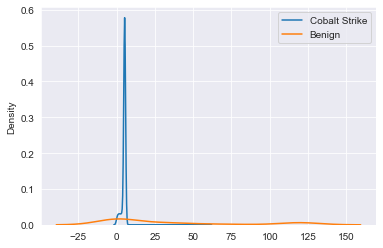

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
headDeltas = df.head(1)[dlt].tolist()
midDeltas = df.loc[df[count] > 500].tail(1)[dlt].tolist()
sns.set_style('darkgrid')
sns.distplot(headDeltas, hist = False, label= 'Cobalt Strike')
sns.distplot(midDeltas, hist = False, label = 'Benign')
plt.legend()